<a href="https://colab.research.google.com/github/kvelez-iastate/S2021_ME592/blob/main/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2 

March 10th, 2021

Kimberly Velez

Kyle Swanton

**Motivation**

This homework is to provide an experience of Data Preparation involved in Data Analytics
for Cyber-Physical Systems.
General Instructions
The dataset and problems for each group are slightly different, but the motivation remains
the same. Following are some instructions for all the theme groups. Specific instructions
for each group shall be provided in the relevant sections.
1. The final code must be pushed to git before the deadline.
2. Use the discussion board in Canvas in case of any issue.

**Expected Outcome**

1. A code pushed in git to preprocess each dataset provided.
2. A presentation video explaining the problem and results(duration must not be less
than 10 mins); we will present this video for some groups in class.


**Design and Manufacturing**

The dataset in DM.zip contains the following:
1. 64 input geometries made of NURBS surface. Each input geometry contains 3 smesh files for three surfaces which are interacting in the analysis. these smesh files contain the position of the control points.
2. Deformed geometry(at 80th time step and 140th time step of the analysis) for the 64 geometries at 5 thickness and 3 pressure conditions.

Each of the geometry is placed in folder run1-64. Each folder contains three smesh files. Each of the smesh file contains the following:

* First 4 lines talk about the no. of components, the DOF, number of nodal points and something about the post-processing. You might find it easy to skip these 4 lines while parsing through the file.
* After the line 4, x,y and z coordinates of each node is specified. For simplicity, all the geometries are having 17 and 12 nodes in two directions of the surface.

Each of the final geometry is named as result tstep temp pressure geometry, where tstep refers to the time step of the deformed geometry (80 and 140). temp refers to the 5 temperatures (300K, 350K, 400K, 450K, 500K) and pressure refers to 3 pressure conditions (76mmHg, 80mmHg, 84mmHg) and geometry refers to the 64 geometries. Each file contains the final deformation of all the nodes of the three surfaces in the same order as the smesh files (skip line 1 which contains time step and analysis relevant details).

In [1]:
# Mount session to Homework 2 folder in Google Drive
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW2', nb_path)
sys.path.insert(0, nb_path)

Mounted at /content/mnt


In [2]:
# Import needed packages

import sys
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE

%matplotlib inline

## Define functions

In [3]:
# Function to take in results file path and return the 3 surfaces in the file location

def read_result_file(filepath):
    
    # read the data file
    data = np.genfromtxt(filepath, skip_header = 1)
    
    # split the data file into the 3 surfaces
    # transpose so that rows correspond to x,y,z coordinates
    surf_1 = data[:204,:].T
    surf_2 = data[204:408,:].T
    surf_3 = data[408:,:].T
    
    # create a single list for all 3 surfaces
    surfaces = [surf_1, surf_2, surf_3]
    
    # return the surface x,y,z data
    return surfaces

In [11]:
# Function to take in the input file path and return the 3 surfaces

def read_input_file(path):
    
    # read the data files
    # transpose so that rows correspond to x,y,z coordinates
    surf_1 = np.genfromtxt(path + '/smesh.1.1.txt', skip_header=5, skip_footer=1, usecols=(0,1,2)).T
    surf_2 = np.genfromtxt(path + '/smesh.1.2.txt', skip_header=5, skip_footer=1, usecols=(0,1,2)).T
    surf_3 = np.genfromtxt(path + '/smesh.1.3.txt', skip_header=5, skip_footer=1, usecols=(0,1,2)).T
    
    # create a single list for all 3 surfaces
    surfaces = [surf_1, surf_2, surf_3]
    
    # return the surface x,y,z data
    return surfaces

In [5]:
# Function to take result file name and parse out metadata of timestep, temperature, pressure, and geometry

def read_result_filename(filename,temperatures,pressures):
    
    # split the filename using '_' as a delimiter
    filename_split = filename.split('_')
    
    # extract the desired parameters from the split filename
    timestep = int(filename_split[1])
    temperature_index = int(filename_split[2][1])
    pressure_index = int(filename_split[3][1])
    geom = int(filename_split[4])
    
    # convert temperature index to actual temperature
    # subtract 1 because python is zero-indexed
    temperature = temperatures[temperature_index-1]
    
    # convert pressure index to actual pressure
    # subtract 1 because python is zero-indexed
    pressure = pressures[pressure_index-1]
    
    # return the desired data
    return [timestep, temperature, pressure, geom]

In [7]:
# Use algorithm from http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/ to whiten data

def whiten_surf(a):
    
    # zero-center the x,y,z data
    means = np.mean(a.T,axis=0)
    a_centered = (a.T - means).T
      
    # calculate covariance matrix according to article
    cov = 1/3 * np.dot(a_centered,a_centered.T)
    
    # calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    
    # calculate the inverse sqrt of eigenvalues
    diag_eigenvalues = np.diag(1/(eigenvalues**0.5))
    
    # rotate data
    rotated_data = np.dot(eigenvectors,a_centered)
    
    # perform whitening
    wpca = np.dot(diag_eigenvalues, rotated_data)
    
    # return the whitened data
    return wpca

In [8]:
# Function to create list of file names from a path

def list_folder_contents(path):
    
    # initialize an empty list
    entries = []
    
    # loop through the folder to retieve its contents
    for entry in os.listdir(path):
        entries.append(entry)
        
    # return the folder contents
    return entries

In [14]:
# Function to vectorize three surfaces into one row

def create_vector_row(ordered_pair):
    
    # pull the required data from the ordered pair
    result_surf_1 = np.concatenate((ordered_pair[1][0][0],ordered_pair[1][0][1],ordered_pair[1][0][2]))
    result_surf_2 = np.concatenate((ordered_pair[1][1][0],ordered_pair[1][1][1],ordered_pair[1][1][2]))
    result_surf_3 = np.concatenate((ordered_pair[1][2][0],ordered_pair[1][2][1],ordered_pair[1][2][2]))

    # create the row array
    row = np.concatenate((result_surf_1,result_surf_2,result_surf_3))
    temp = ordered_pair[0][1]
    press = ordered_pair[0][2]
    geom = ordered_pair[0][3]
   
    # return the row array
    return row, temp, press, geom

## Task 1

Create two ordered pairs of (input,output) corresponding to two time steps. Here, input refers to tuple of (geometry, temperature, pressure). Since, each of the geometry contains 17x12 nodes. Construct an array of shape 17x12x3 for each geometry. Shape of one element of the ordered pair may look something like ([[17,12,3],[1,],[1,]],[[17,12,3]]).

In [12]:
input_path = '/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW2/DM/data/Input_geometry'
result_path = '/content/mnt/My Drive/Colab Notebooks/ME592/ME592_HW2/DM/data/final_geometry'
temperatures = [300, 350, 400, 450, 500]
pressures = [76, 80, 84]

# create a list of result file names
result_file_names = list_folder_contents(result_path)

# initialize an empty list of ordered pairs for the 80 and 140 timesteps
ordered_pairs_80 = []
ordered_pairs_140 = []

# initialize a counter varible so progress can be printed
n = 0

# create an ordered pair for every results file
for filename in result_file_names:
    
    # extract the required parameters from the file name
    timestep, temperature, pressure, geom = read_result_filename(filename, temperatures, pressures)
    
    # load the x,y,z data for all 3 surfaces in the results file
    result_surfs = read_result_file(result_path + '/' + filename)

    # load the x,y,z data for all 3 surfaces in the corresponding input file
    input_surfs = read_input_file(input_path + '/run' + str(geom))
    
    # create an ordered pair per the assignment description
    ordered_pair = [[input_surfs, temperature, pressure, geom], result_surfs]
    
    # append to the appropriate ordered pair list depending on the timestep
    if timestep == 80:
        ordered_pairs_80.append(ordered_pair)
    elif timestep == 140:
        ordered_pairs_140.append(ordered_pair)
    
    # print the number of files that have been read (of 1294 files)
    n=n+1
    print(n)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## Task 2

Consider the input geometry and output geometry to be images with three channels (x, y and z channels instead of RGB channels). Since, the range of x, y
and z channel are completely different, we would like to apply PCA whitening
to normalize the data. Refer to http://ufldl.stanford.edu/wiki/index.php/
Implementing_PCA/Whitening for more information on how to whiten an image.
You would need to whiten all the input geometries, output geometries of both the
time steps.

In [15]:
# create a list of the ordered pairs at each time step that can be iterated on
ordered_pairs_80_140 = [ordered_pairs_80, ordered_pairs_140]

# initialize counter varibles
n = 0
n_surfaces_per_geom = 3

# for each ordered pair list
for i, ordered_pair_list in enumerate(ordered_pairs_80_140):
    
    # for each ordered pair
    for j, ordered_pair in enumerate(ordered_pair_list):
    
        # for each of  3 input surfaces
        for k, surf in enumerate(ordered_pair[0][0]):
            
            # whiten the surface
            ordered_pairs_80_140[i][j][0][0][k] = whiten_surf(surf)
        
        # print the number of files that have been read (of 1294 files)
        n=n+1
        print(n)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


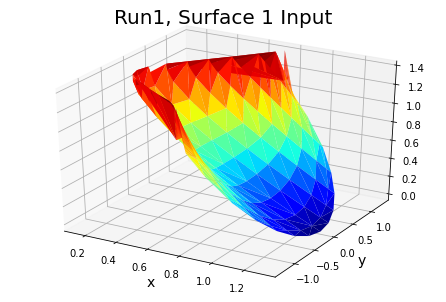

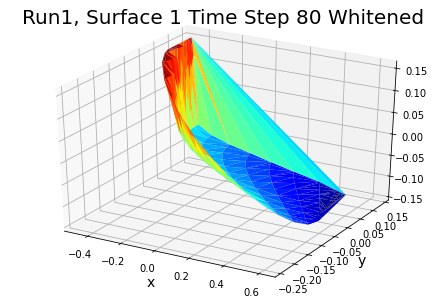

In [17]:
# Visualize a data point to ensure whitening is functioning as expected

# Pull data for one data point
testpoint_filename = 'result_80_t1_p1_1'
timestep, temperature, pressure, geom = read_result_filename(testpoint_filename, temperatures, pressures)
testpoint_result_surfs = read_result_file(result_path + '/' + testpoint_filename)
testpoint_input_surfs = read_input_file(input_path + '/run' + str(geom))
testpoint = [[testpoint_input_surfs, temperature, pressure], testpoint_result_surfs]
testpoint_whiten = whiten_surf(np.array(testpoint[0][0][0]))

# Run 1, Surface 1 Input
fig = plt.figure()
ax = Axes3D(fig)
surf_x = testpoint[0][0][0][0]
surf = ax.plot_trisurf(testpoint[0][0][0][0], testpoint[0][0][0][1], testpoint[0][0][0][2], cmap=cm.jet, linewidth=0.1)
plt.xlabel("x", size=14)
plt.ylabel("y", size=14)
plt.title("Run1, Surface 1 Input",size=20)
plt.show()

# Run 1, Surface 1 Timestep 80 whitened
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(testpoint_whiten[0], testpoint_whiten[1], testpoint_whiten[2], cmap=cm.jet, linewidth=0.1)
plt.xlabel("x", size=14)
plt.ylabel("y", size=14)
plt.title("Run1, Surface 1 Time Step 80 Whitened",size=20)
plt.show()

## Task 3

Once, the output images are whitened, vectorize the output images of time-step 80 and use that for plotting t-SNE. While plotting the t-SNE, you would need to create three plots to mark the labels of the data based on geometry, temperatures and pressures. Comment on the data distribution based on the t-SNE results in terms of geometry, temperatures and pressures. You could use any of the implementations available at https://lvdmaaten.github.io/tsne/.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 647 samples in 0.088s...
[t-SNE] Computed neighbors for 647 samples in 1.780s...
[t-SNE] Computed conditional probabilities for sample 647 / 647
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.066879
[t-SNE] KL divergence after 500 iterations: 0.747045


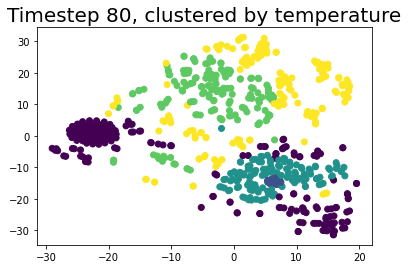

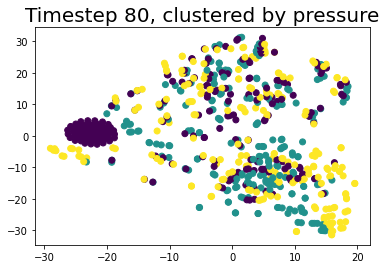

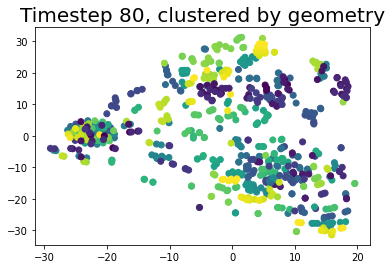

In [27]:
# initialize an empty vector
vector_80 = []
label_temp_80 = []
label_press_80 = []
label_geom_80 = []

for ordered_pair in ordered_pairs_80:
    
    # create the row array
    row_array, row_temp, row_press, row_geom = create_vector_row(ordered_pair)
    
    # append the row array
    vector_80.append(row_array)
    label_temp_80.append(row_temp)
    label_press_80.append(row_press)
    label_geom_80.append(row_geom)
    
# Attempt tsne....
tsne_80 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500, random_state=3)
tsne_results_80 = tsne_80.fit_transform(vector_80)


plt.figure()
plt.title("Timestep 80, clustered by temperature",size=20)
plt.scatter(tsne_results_80[:,0], tsne_results_80[:,1], c=label_temp_80)

plt.figure()
plt.title("Timestep 80, clustered by pressure",size=20)
plt.scatter(tsne_results_80[:,0], tsne_results_80[:,1], c=label_press_80)

plt.figure()
plt.title("Timestep 80, clustered by geometry",size=20)
plt.scatter(tsne_results_80[:,0], tsne_results_80[:,1], c=label_geom_80)

## Task 4

Repeat the same process on time-step 140 as well. Comment if the inference on
data distribution changes for this case.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 647 samples in 0.095s...
[t-SNE] Computed neighbors for 647 samples in 1.434s...
[t-SNE] Computed conditional probabilities for sample 647 / 647
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.586914
[t-SNE] KL divergence after 350 iterations: 1.374420


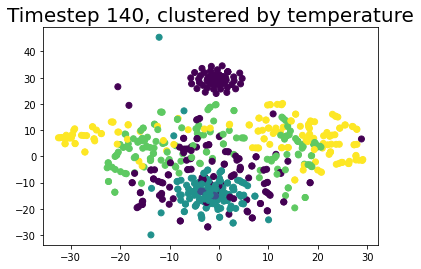

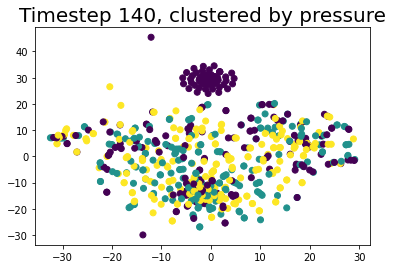

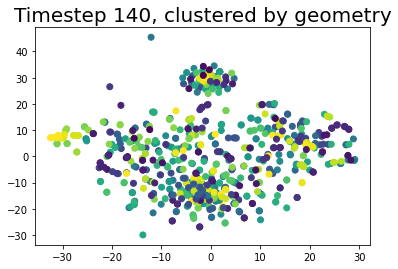

In [23]:
vector_140 = []
label_temp_140 = []
label_press_140 = []
label_geom_140 = []

for ordered_pair in ordered_pairs_140:
    
    # create the row array
    row_array, row_temp, row_press, row_geom = create_vector_row(ordered_pair)
    
    # append the row array
    vector_140.append(row_array)
    label_temp_140.append(row_temp)
    label_press_140.append(row_press)
    label_geom_140.append(row_geom)
    
# Attempt tsne....
tsne_140 = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=350, random_state=3)
tsne_results_140 = tsne_140.fit_transform(vector_140)


plt.figure()
plt.title("Timestep 140, clustered by temperature",size=20)
plt.scatter(tsne_results_140[:,0], tsne_results_140[:,1], c=label_temp_140)

plt.figure()
plt.title("Timestep 140, clustered by pressure",size=20)
plt.scatter(tsne_results_140[:,0], tsne_results_140[:,1], c=label_press_140)

plt.figure()
plt.title("Timestep 140, clustered by geometry",size=20)
plt.scatter(tsne_results_140[:,0], tsne_results_140[:,1], c=label_geom_140)